https://machinelearningmastery.com/how-to-grid-search-triple-exponential-smoothing-for-time-series-forecasting-in-python/
https://www.statsmodels.org/stable/examples/notebooks/generated/exponential_smoothing.html


In [17]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rcParams['figure.figsize'] = (30, 8)
mpl.rcParams['axes.grid'] = True
from scipy.optimize import minimize
from sklearn.metrics import mean_squared_log_error
from sklearn.model_selection import TimeSeriesSplit

In [18]:
# read hotel data
df = pd.read_pickle('../dataset/preprocessed/48_imputed.pkl')
# only select final occupancy
df = df[df['LeadTime']==0]
df['OCC'] = df['ROH']/df['TotalCapacity']
# # timeserise only on ROH
df = df.drop(columns=['ROH','DOW','LeadTime','Price','TotalCapacity'])
df = df.set_index('DOA')
# # Filling missing values
df = df.asfreq(freq='d', method='ffill')
train = df[:'2019-09-30']
test  = df['2019-10-01':]

In [19]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
OCC,728.0,0.893436,0.143506,0.192308,0.866346,0.961538,0.980769,1.0


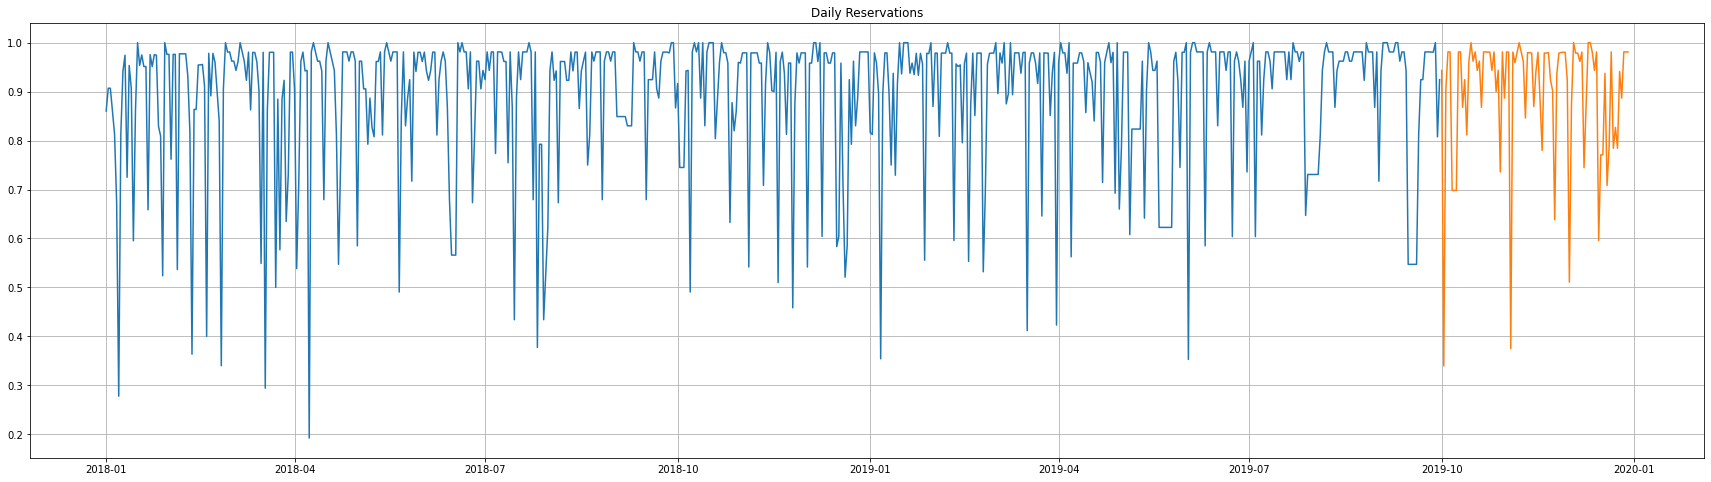

In [20]:
# plt.plot(df['ROH'])
plt.plot(train['OCC'])
plt.plot(test['OCC'])
plt.title('Daily Reservations')
plt.grid(True)
plt.show()

In [21]:
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt

## Simple Eponential Smoothing

In [24]:
model_ses = SimpleExpSmoothing(train,initialization_method="heuristic")
model_ses = model_ses.fit(smoothing_level=0.2)
yfitd_ses = model_ses.fittedvalues
ypred_ses = model_ses.forecast(90)

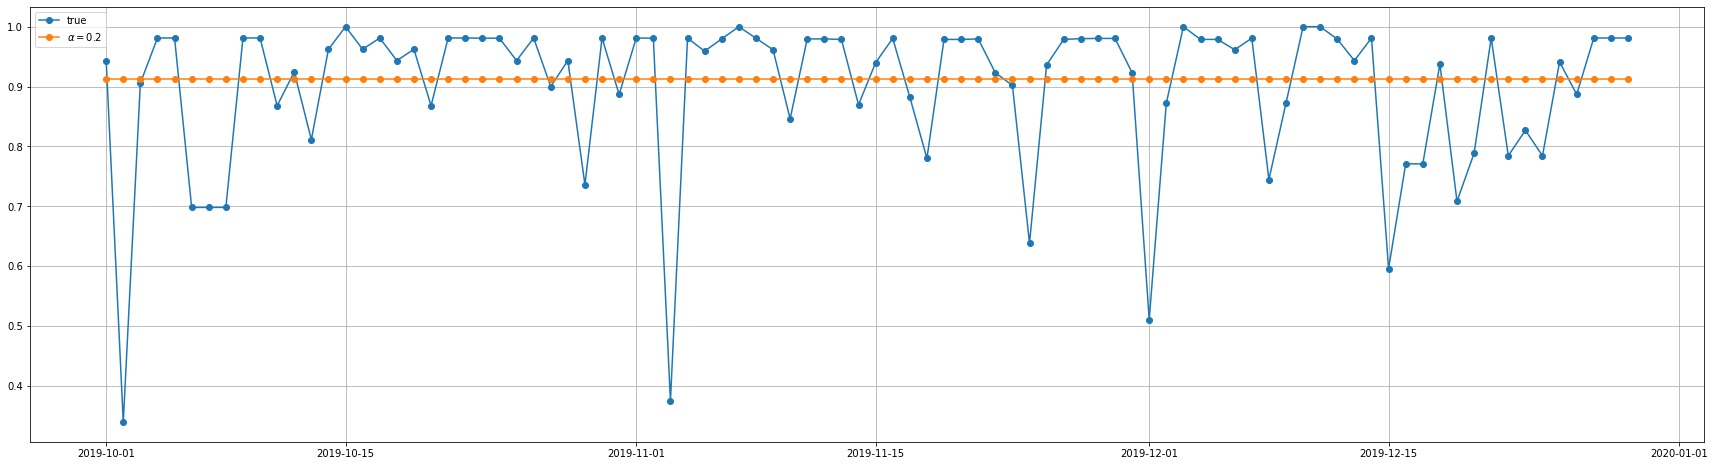

In [25]:
plt.plot(test, marker='o',label='true')
plt.plot(ypred_ses, marker='o',label=r'$\alpha=0.2$')
plt.legend(loc="best")
plt.show()

## Exponential Smoothing 

In [29]:
model_hlt = Holt(train, initialization_method="estimated")
model_hlt = model_hlt.fit(smoothing_level=0.8, smoothing_trend=0.2)
yfitd_hlt = model_hlt.fittedvalues
ypred_hlt = model_hlt.forecast(90)

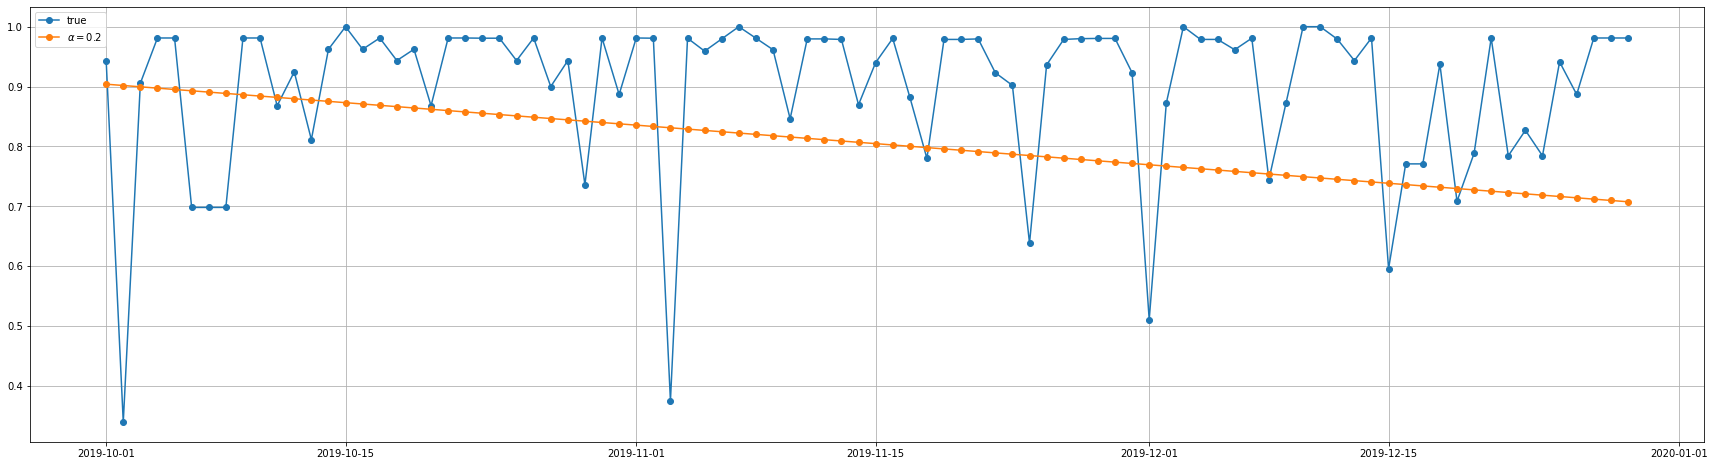

In [30]:
plt.plot(test, marker='o',label='true')
plt.plot(ypred_hlt, marker='o',label=r'$\alpha=0.2$')
plt.legend(loc="best")
plt.show()

In [15]:
fit1 = SimpleExpSmoothing(train, initialization_method="estimated").fit()
fit2 = Holt(train, initialization_method="estimated").fit()
fit3 = Holt(train,exponential=True, initialization_method="estimated").fit()
fit4 = Holt(train,damped_trend=True, initialization_method="estimated").fit(damping_trend=0.98)
fit5 = Holt(train,exponential=True, damped_trend=True, initialization_method="estimated").fit()
params = ['smoothing_level', 'smoothing_trend', 'damping_trend', 'initial_level', 'initial_trend']
results=pd.DataFrame(index=["α","𝛽","𝜙","l_0","b_0","SSE"] ,columns=['SES', "Holt's","Exponential", "Additive", "Multiplicative"])
results["SES"] =            [fit1.params[p] for p in params] + [fit1.sse]
results["Holt's"] =         [fit2.params[p] for p in params] + [fit2.sse]
results["Exponential"] =    [fit3.params[p] for p in params] + [fit3.sse]
results["Additive"] =       [fit4.params[p] for p in params] + [fit4.sse]
results["Multiplicative"] = [fit5.params[p] for p in params] + [fit5.sse]
results

,SES,Holt's,Exponential,Additive,Multiplicative
α,1.490116e-08,1.490116e-08,1.490116e-08,1.490116e-08,1.496389e-08
𝛽,NaN,0.000000e+00,1.834207e-09,1.400198e-11,1.265941e-09
𝜙,NaN,NaN,NaN,9.800000e-01,9.886472e-01
l_0,8.926295e-01,8.735467e-01,8.737979e-01,8.249215e-01,8.405129e-01
b_0,NaN,5.977145e-05,1.000067e+00,1.497120e-03,1.012282e+00
SSE,1.342550e+01,1.334822e+01,1.334869e+01,1.331524e+01,1.330830e+01


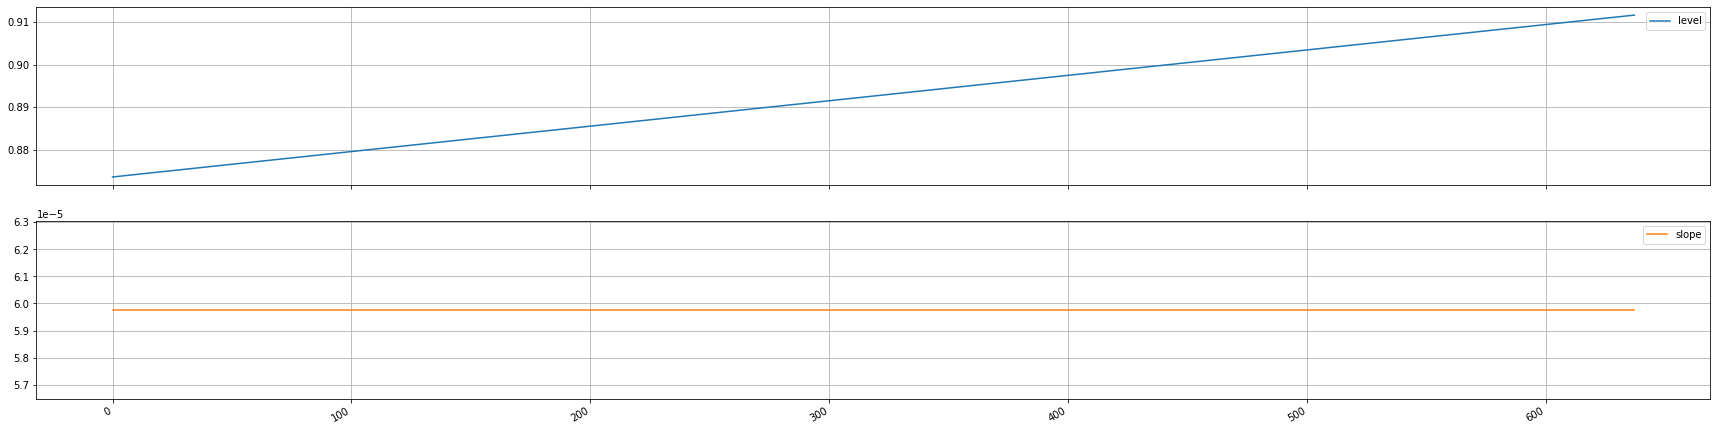

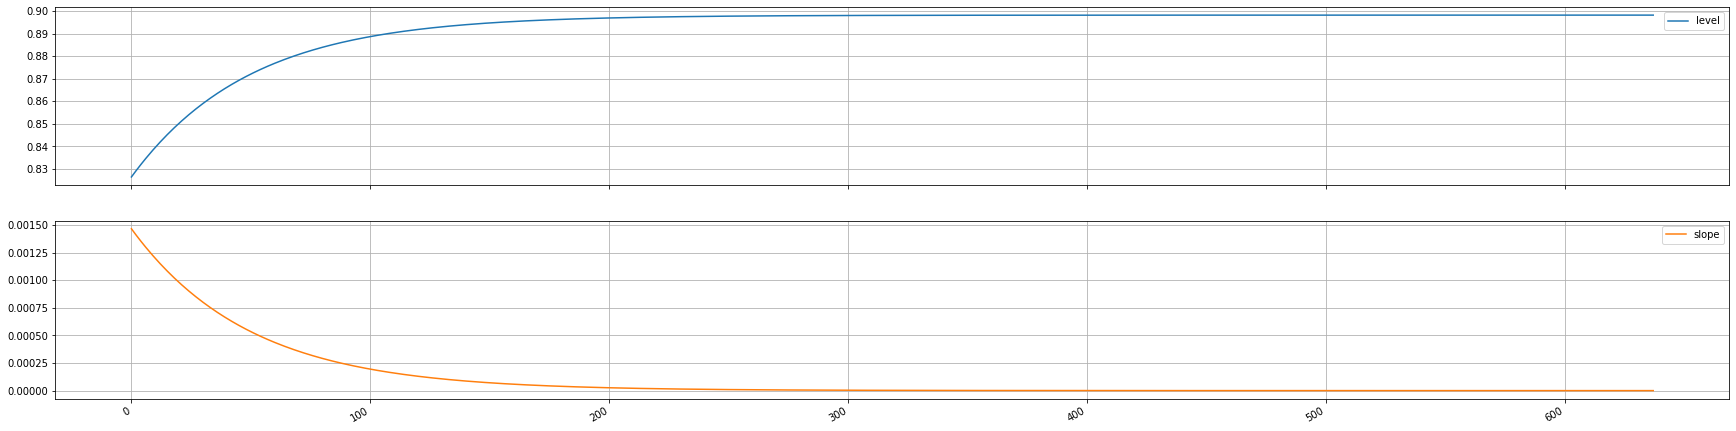

Figure 7.4: Level and slope components for Holt’s linear trend method and the additive damped trend method.


In [48]:
for fit in [fit2,fit4]:
    pd.DataFrame(np.c_[fit.level,fit.trend]).rename(
        columns={0:'level',1:'slope'}).plot(subplots=True)
plt.show()
print('Figure 7.4: Level and slope components for Holt’s linear trend method and the additive damped trend method.')

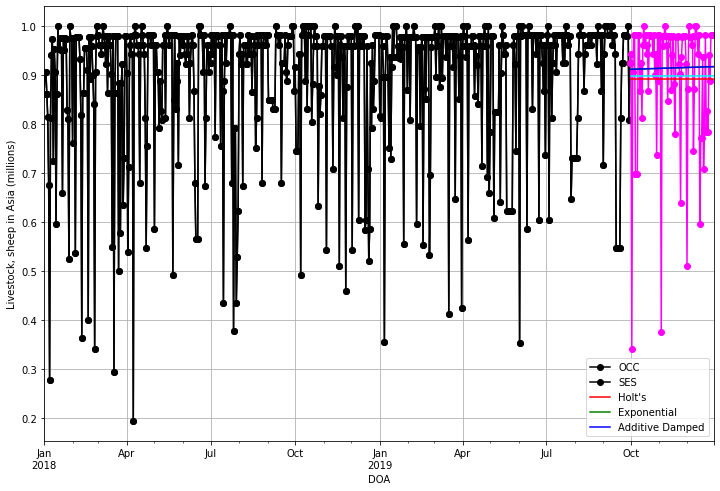

Figure 7.5: Forecasting livestock, sheep in Asia: comparing forecasting performance of non-seasonal methods.


In [20]:
fit1 = SimpleExpSmoothing(train, initialization_method="estimated").fit()
fcast1 = fit1.forecast(91).rename("SES")
fit2 = Holt(train, initialization_method="estimated").fit()
fcast2 = fit2.forecast(91).rename("Holt's")
fit3 = Holt(train, exponential=True, initialization_method="estimated").fit()
fcast3 = fit3.forecast(91).rename("Exponential")
fit4 = Holt(train, damped_trend=True, initialization_method="estimated").fit(damping_trend=0.98)
fcast4 = fit4.forecast(91).rename("Additive Damped")
fit5 = Holt(train, exponential=True, damped_trend=True, initialization_method="estimated").fit()
fcast5 = fit5.forecast(91).rename("Multiplicative Damped")

ax = train.plot(color="black", marker="o", figsize=(12,8))
train.plot(ax=ax, color="black", marker="o", legend=False)
plt.plot(test, marker='o', color='magenta')
fcast1.plot(ax=ax, color='red', legend=True)
fcast2.plot(ax=ax, color='green', legend=True)
fcast3.plot(ax=ax, color='blue', legend=True)
fcast4.plot(ax=ax, color='cyan', legend=True)
# fcast5.plot(ax=ax, color='magenta', legend=True)
ax.set_ylabel('Livestock, sheep in Asia (millions)')
plt.show()
print('Figure 7.5: Forecasting livestock, sheep in Asia: comparing forecasting performance of non-seasonal methods.')

/Users/ahmadabdullahtariq/Documents/Projects/Thesis/.venv/lib/python3.7/site-packages/statsmodels/tsa/holtwinters/model.py:922: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning,


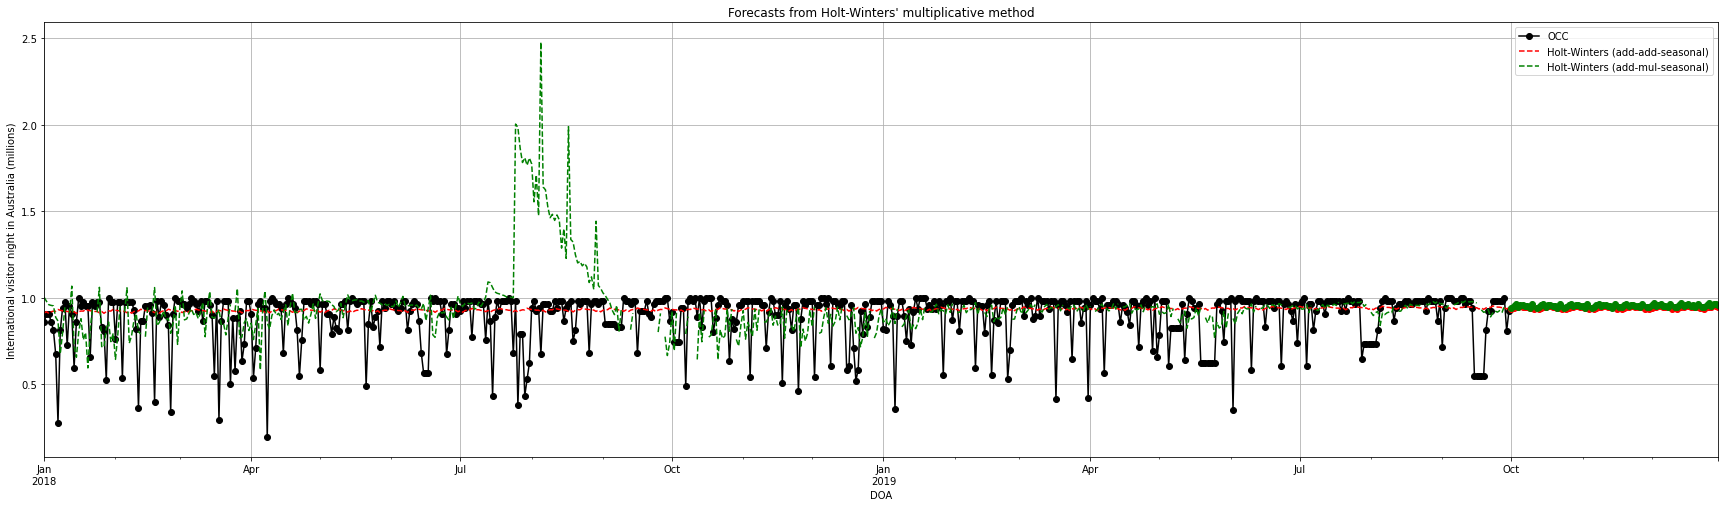

Figure 7.6: Forecasting international visitor nights in Australia using Holt-Winters method with both additive and multiplicative seasonality.


,Additive,Multiplicative,Additive Dam,Multiplica Dam
$\alpha$,3.785113e-07,0.111072,1.490116e-08,1.490116e-08
$\beta$,2.530328e-08,0.012342,7.393214e-10,2.620670e-09
$\phi$,NaN,NaN,9.343088e-01,8.000055e-01
$\gamma$,7.979415e-08,0.032923,2.552797e-15,9.897040e-11
$l_0$,-6.679595e-02,0.010000,-1.054238e-01,0.000000e+00
$b_0$,2.381622e-05,-0.008077,3.555927e-03,-5.366436e-02
SSE,1.432659e+01,NaN,1.431593e+01,1.446553e+01


In [22]:
fit1 = ExponentialSmoothing(train, seasonal_periods=12, trend='add', seasonal='add', use_boxcox=True, initialization_method="estimated").fit()
fit2 = ExponentialSmoothing(train, seasonal_periods=12, trend='add', seasonal='mul', use_boxcox=True, initialization_method="estimated").fit()
fit3 = ExponentialSmoothing(train, seasonal_periods=12, trend='add', seasonal='add', damped_trend=True, use_boxcox=True, initialization_method="estimated").fit()
fit4 = ExponentialSmoothing(train, seasonal_periods=12, trend='add', seasonal='mul', damped_trend=True, use_boxcox=True, initialization_method="estimated").fit()
results=pd.DataFrame(index=[r"$\alpha$",r"$\beta$",r"$\phi$",r"$\gamma$",r"$l_0$","$b_0$","SSE"])
params = ['smoothing_level', 'smoothing_trend', 'damping_trend', 'smoothing_seasonal', 'initial_level', 'initial_trend']
results["Additive"]       = [fit1.params[p] for p in params] + [fit1.sse]
results["Multiplicative"] = [fit2.params[p] for p in params] + [fit2.sse]
results["Additive Dam"]   = [fit3.params[p] for p in params] + [fit3.sse]
results["Multiplica Dam"] = [fit4.params[p] for p in params] + [fit4.sse]

ax = train.plot(marker='o', color='black', title="Forecasts from Holt-Winters' multiplicative method" )
ax.set_ylabel("International visitor night in Australia (millions)")
ax.set_xlabel("Year")
fit1.fittedvalues.plot(ax=ax, style='--', color='red')
fit2.fittedvalues.plot(ax=ax, style='--', color='green')

fit1.forecast(91).rename('Holt-Winters (add-add-seasonal)').plot(ax=ax, style='--', marker='o', color='red', legend=True)
fit2.forecast(91).rename('Holt-Winters (add-mul-seasonal)').plot(ax=ax, style='--', marker='o', color='green', legend=True)

plt.show()
print("Figure 7.6: Forecasting international visitor nights in Australia using Holt-Winters method with both additive and multiplicative seasonality.")

results

In [23]:
fit1 = ExponentialSmoothing(train, seasonal_periods=4, trend='add', seasonal='add', initialization_method="estimated").fit()
fit2 = ExponentialSmoothing(train, seasonal_periods=4, trend='add', seasonal='mul', initialization_method="estimated").fit()

In [24]:
df = pd.DataFrame(np.c_[train, fit1.level, fit1.trend, fit1.season, fit1.fittedvalues],
                  columns=[r'$y_t$',r'$l_t$',r'$b_t$',r'$s_t$',r'$\hat{y}_t$'],index=train.index)
df.append(fit1.forecast(8).rename(r'$\hat{y}_t$').to_frame(), sort=True)

,$\hat{y}_t$,$b_t$,$l_t$,$s_t$,$y_t$
2018-01-01,0.874659,0.00006,0.848423,0.026236,0.860465
2018-01-02,0.871931,0.00006,0.848483,0.023448,0.906977
2018-01-03,0.871714,0.00006,0.848543,0.023172,0.906977
2018-01-04,0.876497,0.00006,0.848602,0.027895,0.860465
2018-01-05,0.874898,0.00006,0.848662,0.026236,0.813953
...,...,...,...,...,...
2019-10-04,0.910150,NaN,NaN,NaN,NaN
2019-10-05,0.909933,NaN,NaN,NaN,NaN
2019-10-06,0.914717,NaN,NaN,NaN,NaN
2019-10-07,0.913117,NaN,NaN,NaN,NaN


In [25]:
df = pd.DataFrame(np.c_[train, fit2.level, fit2.trend, fit2.season, fit2.fittedvalues],
                  columns=[r'$y_t$',r'$l_t$',r'$b_t$',r'$s_t$',r'$\hat{y}_t$'],index=train.index)
df.append(fit2.forecast(8).rename(r'$\hat{y}_t$').to_frame(), sort=True)

,$\hat{y}_t$,$b_t$,$l_t$,$s_t$,$y_t$
2018-01-01,0.874614,0.000063,0.919959,0.950709,0.860465
2018-01-02,0.871770,0.000063,0.920022,0.947553,0.906977
2018-01-03,0.871795,0.000063,0.920085,0.947515,0.906977
2018-01-04,0.876544,0.000063,0.920148,0.952612,0.860465
2018-01-05,0.874853,0.000063,0.920211,0.950709,0.813953
...,...,...,...,...,...
2019-10-04,0.909932,NaN,NaN,NaN,NaN
2019-10-05,0.909955,NaN,NaN,NaN,NaN
2019-10-06,0.914910,NaN,NaN,NaN,NaN
2019-10-07,0.913142,NaN,NaN,NaN,NaN


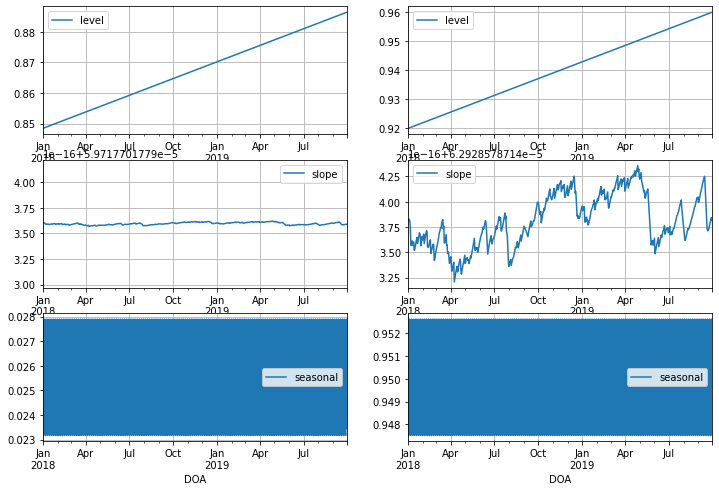

In [57]:
states1 = pd.DataFrame(np.c_[fit1.level, fit1.trend, fit1.season], columns=['level','slope','seasonal'], index=train.index)
states2 = pd.DataFrame(np.c_[fit2.level, fit2.trend, fit2.season], columns=['level','slope','seasonal'], index=train.index)
fig, [[ax1, ax4],[ax2, ax5], [ax3, ax6]] = plt.subplots(3, 2)
states1[['level']].plot(ax=ax1)
states1[['slope']].plot(ax=ax2)
states1[['seasonal']].plot(ax=ax3)
states2[['level']].plot(ax=ax4)
states2[['slope']].plot(ax=ax5)
states2[['seasonal']].plot(ax=ax6)
plt.show()

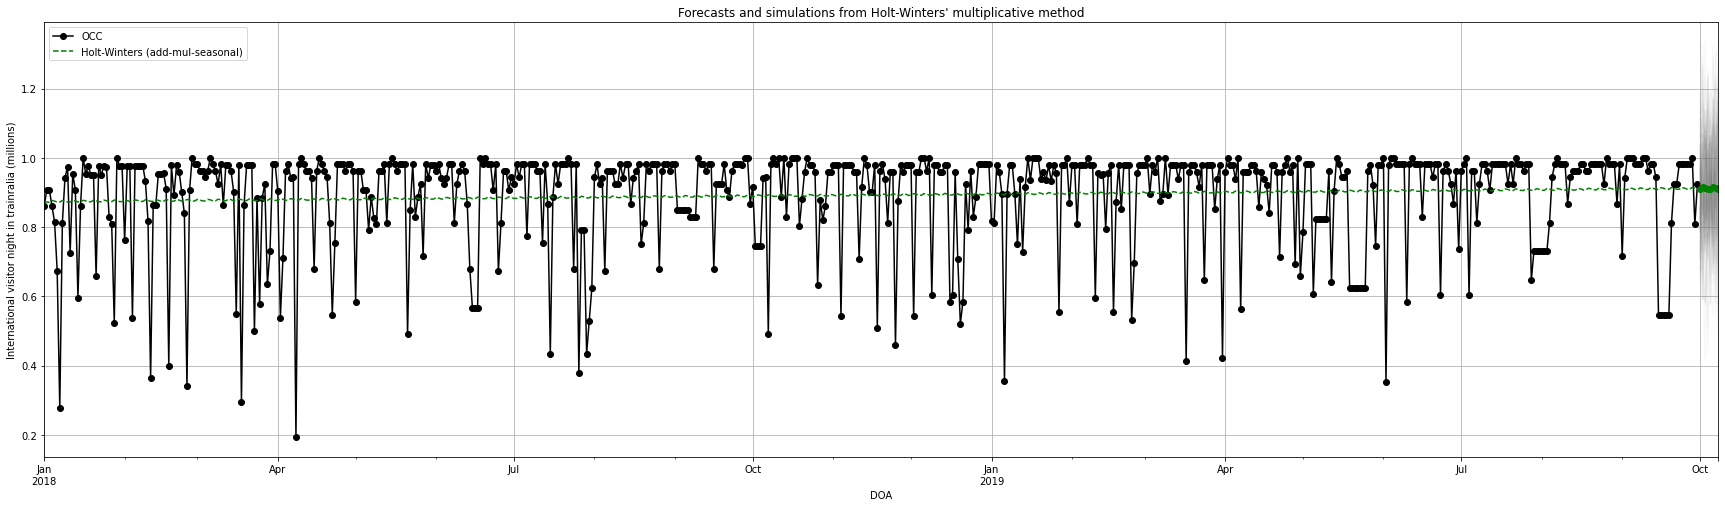

In [58]:
fit = ExponentialSmoothing(train, seasonal_periods=4, trend='add', seasonal='mul', initialization_method="estimated").fit()
simulations = fit.simulate(8, repetitions=100, error='mul')

ax = train.plot( marker='o', color='black',
               title="Forecasts and simulations from Holt-Winters' multiplicative method" )
ax.set_ylabel("International visitor night in trainralia (millions)")
ax.set_xlabel("Year")
fit.fittedvalues.plot(ax=ax, style='--', color='green')
simulations.plot(ax=ax, style='-', alpha=0.05, color='grey', legend=False)
fit.forecast(8).rename('Holt-Winters (add-mul-seasonal)').plot(ax=ax, style='--', marker='o', color='green', legend=True)
plt.show()

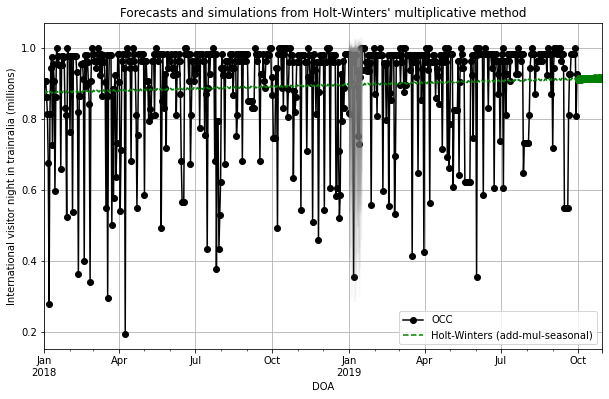

In [62]:
fit = ExponentialSmoothing(train, seasonal_periods=4, trend='add', seasonal='mul', initialization_method="estimated").fit()
simulations = fit.simulate(16, anchor='2019-01-01', repetitions=100, error='mul', random_errors='bootstrap')

ax = train.plot(figsize=(10,6), marker='o', color='black',
               title="Forecasts and simulations from Holt-Winters' multiplicative method" )
ax.set_ylabel("International visitor night in trainralia (millions)")
ax.set_xlabel("Year")
fit.fittedvalues.plot(ax=ax, style='--', color='green')
simulations.plot(ax=ax, style='-', alpha=0.05, color='grey', legend=False)
fit.forecast(30).rename('Holt-Winters (add-mul-seasonal)').plot(ax=ax, style='--', marker='o', color='green', legend=True)
plt.show()

## test

In [47]:
# one-step Holt Winter's Exponential Smoothing forecast
def exp_smoothing_forecast(history, config):
	t,d,s,p,b,r = config
	# define model model
	history = array(history)
	model = ExponentialSmoothing(history, trend=t, damped=d, seasonal=s, seasonal_periods=p)
	# fit model
	model_fit = model.fit(optimized=True, use_boxcox=b, remove_bias=r)
	# make one step forecast
	yhat = model_fit.predict(len(history), len(history))
	return yhat[0]

In [48]:
# split a univariate dataset into train/test sets
def train_test_split(data, n_test):
	return data[:-n_test], data[-n_test:]

In [54]:
# root mean squared error or rmse
def measure_rmse(actual, predicted):
	return sqrt(mean_squared_error(actual, predicted))

In [55]:
# walk-forward validation for univariate data
def walk_forward_validation(data, n_test, cfg):
	predictions = list()
	# split dataset
	train, test = train_test_split(data, n_test)
	# seed history with training dataset
	history = [x for x in train]
	# step over each time-step in the test set
	for i in range(len(test)):
		# fit model and make forecast for history
		yhat = exp_smoothing_forecast(history, cfg)
		# store forecast in list of predictions
		predictions.append(yhat)
		# add actual observation to history for the next loop
		history.append(test[i])
	# estimate prediction error
	error = measure_rmse(test, predictions)
	return error

In [56]:
def score_model(data, n_test, cfg, debug=False):
	result = None
	# convert config to a key
	key = str(cfg)
	# show all warnings and fail on exception if debugging
	if debug:
		result = walk_forward_validation(data, n_test, cfg)
	else:
		# one failure during model validation suggests an unstable config
		try:
			# never show warnings when grid searching, too noisy
			with catch_warnings():
				filterwarnings("ignore")
				result = walk_forward_validation(data, n_test, cfg)
		except:
			error = None
	# check for an interesting result
	if result is not None:
		print(' > Model[%s] %.3f' % (key, result))
	return (key, result)

In [57]:
executor = Parallel(n_jobs=cpu_count(), backend='multiprocessing')